In [416]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append("/home/andang/workspace/Computational_Vision/HL2/Hololens-Project/hl2ss/viewer")
import cv2
import trimesh
import pyrender

from mpl_toolkits import mplot3d
import json
import hl2ss
import hl2ss_3dcv
from PoseVisualizer import CameraPoseVisualizer

%matplotlib inline

In [417]:
CALIB_PATH = '/home/andang/workspace/Computational_Vision/HL2/Hololens-Project/datasets/'
def get_all_calibration():
    calib_pv = hl2ss_3dcv._load_calibration_pv(CALIB_PATH+'calibrations/personal_video')
    calib_lt = hl2ss_3dcv._load_calibration_rm_depth_longthrow(CALIB_PATH+'calibrations/rm_depth_longthrow')
    calib_ahat = hl2ss_3dcv._load_calibration_rm_depth_ahat(CALIB_PATH+'calibrations/rm_depth_ahat')
    calib_rf = hl2ss_3dcv._load_calibration_rm_vlc(CALIB_PATH+'calibrations/rm_vlc_rightfront')
    calib_lf = hl2ss_3dcv._load_calibration_rm_vlc(CALIB_PATH+'calibrations/rm_vlc_leftfront')
    calib_rr = hl2ss_3dcv._load_calibration_rm_vlc(CALIB_PATH+'calibrations/rm_vlc_rightright')
    calib_lr = hl2ss_3dcv._load_calibration_rm_vlc(CALIB_PATH+'calibrations/rm_vlc_leftleft')
    
    uv2xy = hl2ss_3dcv.compute_uv2xy(calib_ahat.intrinsics, hl2ss.Parameters_RM_DEPTH_AHAT.WIDTH, hl2ss.Parameters_RM_DEPTH_AHAT.HEIGHT)
    xy1, scale = hl2ss_3dcv.rm_depth_compute_rays(uv2xy, calib_ahat.scale)
    
    #return all calibrations + xy1 + scale
    return calib_pv, calib_ahat, calib_lt, calib_lf, calib_rf, calib_lr, calib_rr, xy1, scale

In [418]:
calib_pv, calib_ahat, calib_lt, calib_lf, calib_rf, calib_lr, calib_rr, xy, depth_scale = get_all_calibration()

In [419]:
 #code to load up poses
PATH = '/home/andang/workspace/Computational_Vision/HL2/Hololens-Project/datasets/an_place/vid2/'

with open(PATH+'vlc1_pose.json') as f: # vlc LF
    j_vlc_lf = json.load(f)
with open(PATH+'vlc3_pose.json') as f:
    j_vlc_rf = json.load(f)
with open(PATH+'depth_ahat_pose.json') as f: # long throw
    j_ahat = json.load(f)
with open(PATH+'pv_pose.json') as f: # long throw
    j_pv = json.load(f)
with open(PATH+'vlc2_pose.json') as f: # long throw
    j_vlc_ll = json.load(f)
with open(PATH+'vlc4_pose.json') as f: # long throw
    j_vlc_rr = json.load(f)
    
tstamps = sorted(j_ahat.keys())

def get_im(tstamp, root_path):
    return cv2.imread(root_path+tstamp+'.png')

def get_posed_data(idx, sensor_name, pose_name):
    
    if type(idx) is str:
        tstamp_name = idx
    else:
        tstamp_name = tstamps[idx]
    im = cv2.imread(PATH+sensor_name+'/'+tstamp_name+'.png')
    pose = pose_name[tstamp_name]
    return im, np.array(pose)

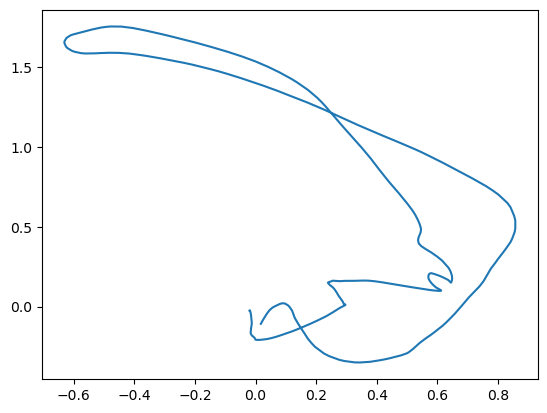

In [420]:
tstep = len(tstamps)
xs = np.zeros(tstep)
ys = np.zeros(tstep)
zs = np.zeros(tstep)
for i in range(tstep):
    x,y,z = np.array(j_pv[tstamps[i]]).T[:3,3]
    
    xs[i] = x
    ys[i] = y
    zs[i] = z
    
plt.plot(xs,zs)
plt.show()

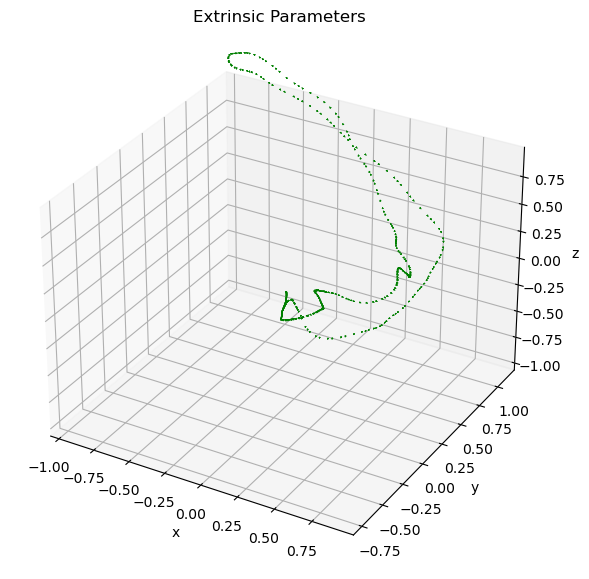

In [421]:
scale = 1
focal_scale = 0.01



for i in range(tstep):
    # flip = np.array([[1,0,0,0],[0,0,-1,0],[0,1,0,0],[0,0,0,1]])
    flip = np.eye(4)
    pose = flip @ np.array(j_pv[tstamps[i]]).T
    
    
    
    if i == 0:
        x,y,z = pose[:3,3]
        visualizer = CameraPoseVisualizer([x-scale, x+scale], [y-scale,y+scale], [z-scale, z+scale])
        
    visualizer.extrinsic2pyramid(pose, 'g', focal_len_scaled=focal_scale)
visualizer.show()

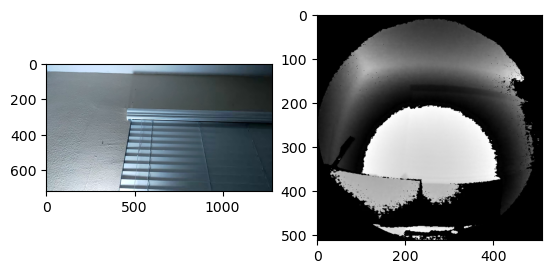

In [422]:
#display code to see what we see throughout time
time = 0

im_pv, pose_pv = get_posed_data(time,'pv',j_pv)
im_ahat, pose_ahat = get_posed_data(time,'depth_ahat',j_ahat)

im_lf, pose_lf = get_posed_data(time,'vlc_lf',j_vlc_lf)
im_ll, pose_ll = get_posed_data(time,'vlc_ll',j_ahat)
im_rf, pose_rf = get_posed_data(time,'vlc_rf',j_ahat)
im_rr, pose_rr = get_posed_data(time,'vlc_rr',j_ahat)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(im_pv)
axs[1].imshow(im_ahat)

In [423]:
print(pose_ahat.T)

[[ 0.03065115 -0.99952912 -0.00153375 -0.06768306]
 [-0.81224859 -0.02580249  0.58274072  0.18296438]
 [-0.58250582 -0.01661599 -0.812657   -0.01523748]
 [ 0.          0.          0.          1.        ]]


In [424]:
#adding scene to interface with pyrender
MESH_PATH = '/home/andang/workspace/Computational_Vision/HL2/Hololens-Project/datasets/an_place/'
intrinsics = calib_ahat.intrinsics.T[:3,:3]

'''
    flipper notes:
        -> in pose data, -z is forward
                         +y is up
                         +x is right
        -> hololens extrinsics
                        -y is right
                        -x is up
                        +z is forward
'''

flipper = np.array([[0,-1,0,0],[-1,0,0,0],[0,0,-1,0],[0,0,0,1]])
# flipper[:3,:3] *= -1
# poser = pose_pv.T @ np.linalg.inv(calib_ahat.extrinsics.T)
poser =  pose_pv.T


fuze_trimesh = trimesh.load(MESH_PATH+'SpatialMapping.obj')
print(fuze_trimesh)
mesh = pyrender.Mesh.from_trimesh(fuze_trimesh)
scene = pyrender.Scene()
scene.add(mesh,name='scene')


camera = pyrender.IntrinsicsCamera(fx=2*intrinsics[0,0],fy=2*intrinsics[1,1],cx=intrinsics[0,2],cy=intrinsics[1,2])
scene.add(camera, name='camera',pose=poser)

light = pyrender.SpotLight(color=np.ones(3), intensity=4.0,
                           innerConeAngle=np.pi/2.0,
                           outerConeAngle=np.pi/2.0)

scene.add(light, name='light',pose=poser)

<trimesh.Trimesh(vertices.shape=(11727, 3), faces.shape=(20751, 3))>


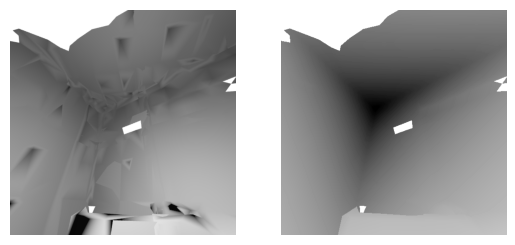

In [425]:
r = pyrender.OffscreenRenderer(512, 512) #specifies heightxwidth of image
color, depth = r.render(scene) #create the images

plt.figure()
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(color)
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(depth, cmap=plt.cm.gray_r)
plt.show()

In [426]:
import open3d as o3d

In [427]:
def transform(points, transform4x4):
    return points @ transform4x4[:3, :3] + transform4x4[3, :3].reshape(([1] * (len(points.shape) - 1)).append(3))
def rm_depth_undistort(depth, undistort_map):
    return cv2.remap(depth, undistort_map[:, :, 0], undistort_map[:, :, 1], cv2.INTER_NEAREST)
def block_to_list(points):
    return points.reshape((-1, points.shape[-1]))
def integrate(calib_ahat, depth, depth_pose, rays, scale, data_vlc_payload, calibration_vlc):
    depth = rm_depth_undistort(depth, calib_ahat.undistort_map) / scale
    depth = depth[:, :, np.newaxis]
    lt_points = rays * depth
    lt_to_world        = np.linalg.inv(calib_ahat.extrinsics) @ depth_pose
    world_points       = transform(lt_points, lt_to_world)
    
    color = cv2.remap(data_vlc_payload, calibration_vlc.undistort_map[:, :, 0], calibration_vlc.undistort_map[:, :, 1], cv2.INTER_LINEAR)
    
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(block_to_list(world_points))
    # pcd.colors = o3d.utility.Vector3dVector(block_to_list(color))
    return pcd

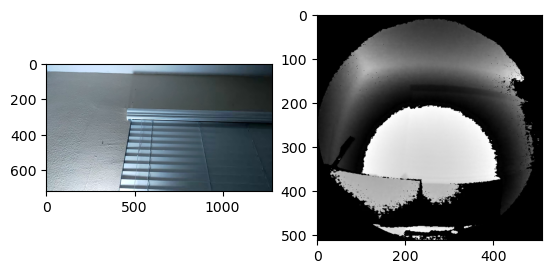

In [428]:
#display code to see what we see throughout time
time = 0

im_pv, pose_pv = get_posed_data(time,'pv',j_pv)
im_ahat, pose_ahat = get_posed_data(time,'depth_ahat',j_ahat)

im_lf, pose_lf = get_posed_data(time,'vlc_lf',j_vlc_lf)
im_ll, pose_ll = get_posed_data(time,'vlc_ll',j_ahat)
im_rf, pose_rf = get_posed_data(time,'vlc_rf',j_ahat)
im_rr, pose_rr = get_posed_data(time,'vlc_rr',j_ahat)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(im_pv)
axs[1].imshow(im_ahat)

pcd1 = integrate(calib_ahat,im_ahat.mean(axis=2), pose_ahat, xy, depth_scale, im_lf, calib_lf)

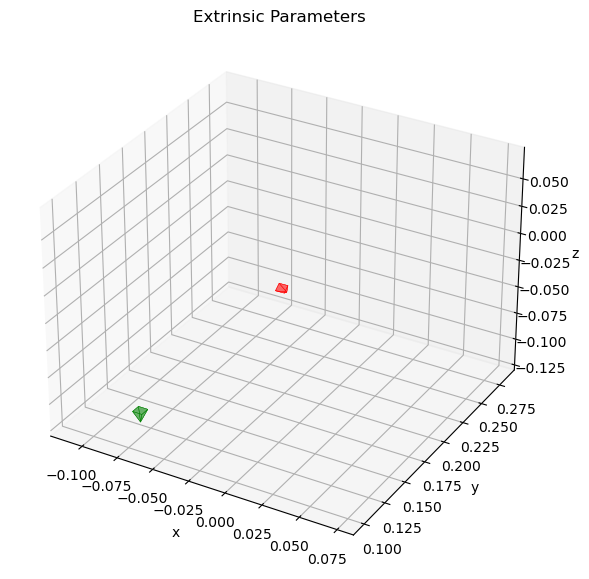

In [429]:
scale = 0.1
focal_scale = 0.01
x,y,z = pose_pv.T[:3,3]
visualizer = CameraPoseVisualizer([x-scale, x+scale], [y-scale,y+scale], [z-scale, z+scale])

#extrinsic is 4x4
visualizer.extrinsic2pyramid(pose_pv.T , 'r', focal_len_scaled=focal_scale)
visualizer.extrinsic2pyramid(np.eye(4), 'g', focal_len_scaled=focal_scale)
visualizer.show()

In [430]:
pose_pv.T

array([[ 0.99960369, -0.02767469,  0.00546691, -0.01844347],
       [ 0.02512792,  0.78545517, -0.6184113 ,  0.1914489 ],
       [ 0.01282051,  0.61830151,  0.7858389 , -0.02574532],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

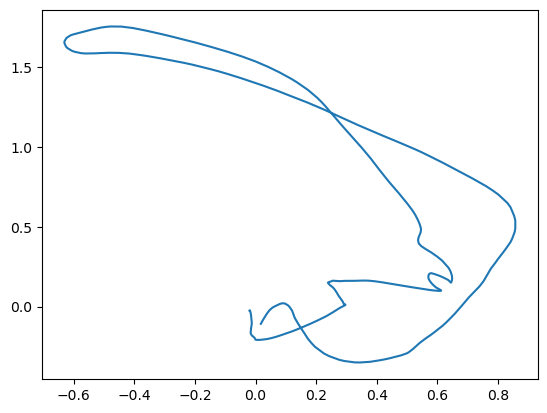

In [431]:
tstep = len(tstamps)
xs = np.zeros(tstep)
ys = np.zeros(tstep)
zs = np.zeros(tstep)
for i in range(tstep):
    x,y,z = np.array(j_pv[tstamps[i]]).T[:3,3]
    
    xs[i] = x
    ys[i] = y
    zs[i] = z
    
plt.plot(xs,zs)
plt.show()


pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.vstack((xs,ys,zs)).T)

In [432]:
mesh = o3d.io.read_triangle_mesh(MESH_PATH+"SpatialMapping.obj")

In [433]:
o3d.visualization.draw_geometries([mesh,pcd], point_show_normal=True, mesh_show_wireframe=True, mesh_show_back_face=True)

In [434]:
# PATH = '/home/andang/workspace/CV_Lab/Hololens-Project/datasets/john_place/raw-05-09-18-46/'
PATH = '/home/andang/workspace/Computational_Vision/HL2/Hololens-Project/datasets/an_place/vid2/'
PATH_MESH = PATH + 'mesh/'
# PATH_MESH = PATH + 'gt_mesh/'

In [435]:
mesh_hmap = {}

for path in os.listdir(PATH_MESH):
    split_names = (path.split('.txt')[0]).split('_')
    info_type = split_names[1]
    timestamp = split_names[2]
    index = split_names[3]
    data = np.loadtxt(PATH_MESH+path) #load up info

    if not (timestamp in mesh_hmap):
        mesh_hmap[timestamp] = {}

    if not index in mesh_hmap[timestamp]:
        mesh_hmap[timestamp][index] = {}


    mesh_hmap[timestamp][index][info_type] = data

In [436]:
#open3d rendering
open3d_meshes = []

for timestamp,j in mesh_hmap.items():
    im_pv1, pose_pv1 = get_posed_data(timestamp,'pv',j_pv)
    pose_pv1 = np.array(pose_pv1)
    
    for i,j in mesh_hmap[timestamp].items():
        vertex_positions = j['vertex'].copy()
        triangle_indices = j['triangles'].copy()
        pose = j['pose'].copy()
        vertex_position_scale = j['vertexscale'].copy()
        vertex_normals = j['normals'].copy()

        vertex_positions[:, 0:3] = vertex_positions[:, 0:3] * vertex_position_scale
        # vertex_positions = (vertex_positions/vertex_positions[:,3:]) @ pose
        vertex_positions = (vertex_positions) @ pose
        
        # vertex_positions = vertex_positions @ pose_pv1
        
        
        d = np.linalg.norm(vertex_normals, axis=1)
        vertex_normals[d > 0, :] = vertex_normals[d > 0, :] / d[d > 0, np.newaxis]
        vertex_normals = vertex_normals @ pose

        open3d_mesh = o3d.geometry.TriangleMesh()
        open3d_mesh.vertices = o3d.utility.Vector3dVector(vertex_positions[:,0:3])
        open3d_mesh.vertex_colors = o3d.utility.Vector3dVector(vertex_normals[:, 0:3])
        open3d_mesh.triangles = o3d.utility.Vector3iVector(triangle_indices)
        open3d_meshes.append(open3d_mesh)
        
    break
    

o3d.visualization.draw_geometries(open3d_meshes + [pcd], point_show_normal=True, mesh_show_wireframe=True,mesh_show_back_face=True)

In [437]:
pcdi = o3d.geometry.PointCloud()
pcdi.points = o3d.utility.Vector3dVector(np.array([[0,0,0]]))
o3d.visualization.draw_geometries(open3d_meshes + [pcdi], point_show_normal=True, mesh_show_wireframe=True,mesh_show_back_face=True)

In [438]:
o3d.visualization.draw_geometries(open3d_meshes + [pcd1], point_show_normal=True, mesh_show_wireframe=True,mesh_show_back_face=True)

In [439]:
full_mesh = o3d.geometry.TriangleMesh()
for open3d_mesh in open3d_meshes:
    full_mesh += open3d_mesh

In [440]:
o3d.io.write_triangle_mesh(filename='this.obj',mesh=full_mesh,write_ascii=True,write_vertex_normals=True,write_vertex_colors=True,write_triangle_uvs=True)

True

In [441]:
def rm_depth_undistort(depth, undistort_map):
    return cv2.remap(depth, undistort_map[:, :, 0], undistort_map[:, :, 1], cv2.INTER_NEAREST)

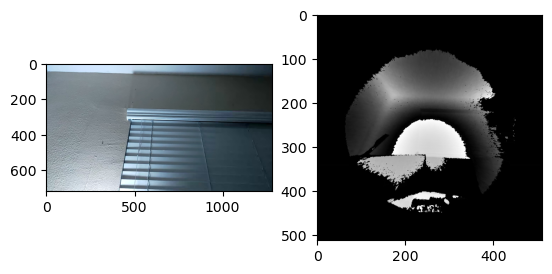

In [444]:
#display code to see what we see throughout time
time = 0

im_pv, pose_pv = get_posed_data(time,'pv',j_pv)
im_ahat, pose_ahat = get_posed_data(time,'depth_ahat',j_ahat)

im_ahat = rm_depth_undistort(im_ahat, calib_ahat.undistort_map)

im_lf, pose_lf = get_posed_data(time,'vlc_lf',j_vlc_lf)
im_ll, pose_ll = get_posed_data(time,'vlc_ll',j_ahat)
im_rf, pose_rf = get_posed_data(time,'vlc_rf',j_ahat)
im_rr, pose_rr = get_posed_data(time,'vlc_rr',j_ahat)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(im_pv)
axs[1].imshow(im_ahat)

In [445]:
fuze_trimesh = trimesh.base.Trimesh(vertices=np.asarray(full_mesh.vertices,dtype=np.float32),\
                                    faces=np.asarray(full_mesh.triangles,dtype=np.int64),\
                                    vertex_normals=np.asarray(full_mesh.vertex_colors,dtype=np.float32))

fuze_trimesh.invert()


In [463]:
#adding scene to interface with pyrender
intrinsics = calib_ahat.intrinsics.T[:3,:3]

# poser = pose_ahat.T @ np.linalg.inv(calib_ahat.extrinsics.T)
poser = pose_ahat.T

mesh = pyrender.Mesh.from_trimesh(fuze_trimesh)
# scene = pyrender.Scene()
scene = pyrender.Scene(ambient_light = [0.3,0.3,0.3, 1.0])
scene.add(mesh,name='scene')


# camera = pyrender.IntrinsicsCamera(fx=1*intrinsics[0,0],fy=1*intrinsics[1,1],cx=intrinsics[0,2],cy=intrinsics[1,2])
camera = pyrender.IntrinsicsCamera(fx=1*intrinsics[0,0],fy=1*intrinsics[1,1],cx=256,cy=256)
scene.add(camera, name='camera',pose=poser)

light = pyrender.SpotLight(color=np.ones(3), intensity=100.0,
                           innerConeAngle=np.pi/2.0,
                           outerConeAngle=np.pi/2.0)

scene.add(light, name='light',pose=poser)

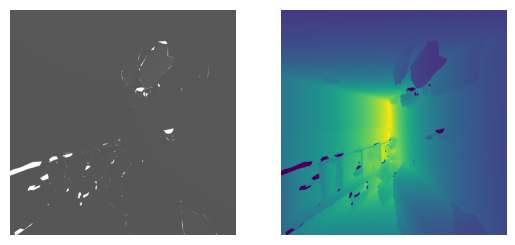

In [464]:
r = pyrender.OffscreenRenderer(512, 512) #specifies heightxwidth of image
color, depth = r.render(scene) #create the images

# color = color.transpose(1,0,2)[:,::-1]

plt.figure()
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(color)
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(depth)
plt.show()

In [465]:
test_ahat = im_ahat.mean(axis=2)
test_depth = depth

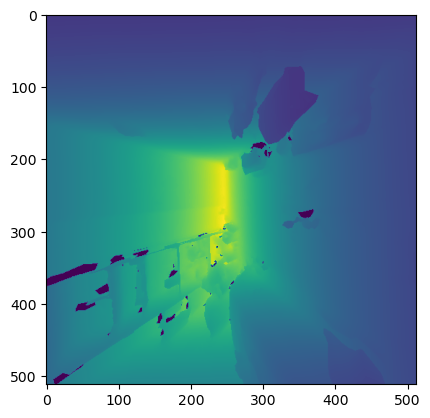

In [466]:
plt.imshow(test_depth)

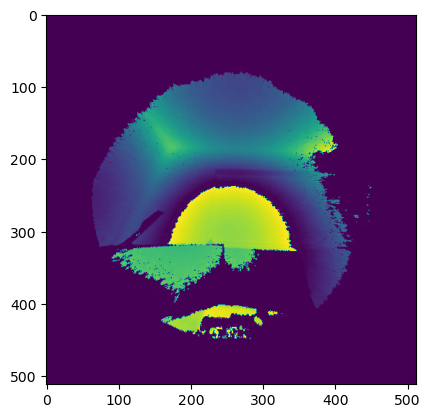

In [467]:
plt.imshow(test_ahat)